In [1]:
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns

In [2]:
def create_distance_plot(distances, top_dist_to_show=500):
    # Create cumulative distribution plot
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, figsize=(6, 6), dpi=150)
    
    axs[0].set_title('Cumulative Euclidean Distances for Camera Jitter', fontsize=15)
    axs[0].set_ylabel('Cumulative \n % of Frames')
    axs[0].set_xlim(0, top_dist_to_show)
    axs[0].grid(False)
    
    # Create histogram and cumulative distribution
    sns.kdeplot(distances, cumulative=True, label='Left Eye', ax=axs[0], linewidth=4, c='black')
    
    axs[1].hist(distances, bins=np.linspace(0, top_dist_to_show, 20), log=False, color='black')

    # Set title and labels
    title = 'Image displacement histogram'
    axs[1].set_title(title, fontsize=15)
    axs[1].set_xlabel('Euclidean Displacement [$\mu$m]', fontsize=15)
    axs[1].set_xscale('linear')
    axs[1].set_yscale('linear')
    axs[1].set_ylabel('Frame count', fontsize=15)

    # Adjust tick label sizes
    axs[1].tick_params(axis='x', which='major', labelsize=15)

    # Set white background and black text
    axs[1].set_facecolor('white')
    axs[1].title.set_color('black')
    axs[1].xaxis.label.set_color('black')
    axs[1].yaxis.label.set_color('black')
    axs[1].tick_params(colors='black')
    axs[1].grid(False)

    plt.tight_layout()

    return fig, axs
def add_intermediate_elements(input_vector, gap_to_bridge):
    # Step 1: Calculate differences between each element
    differences = np.diff(input_vector)

    # Step 2: Add intervening elements based on the diff_threshold
    output_vector = [input_vector[0]]
    for i, diff in enumerate(differences):
        if diff < gap_to_bridge:
            # Add intervening elements
            output_vector.extend(range(input_vector[i] + 1, input_vector[i + 1]))

        # Add the next element from the original vector
        output_vector.append(input_vector[i + 1])

    return np.sort(np.unique(output_vector))

def find_jittery_frames(block, eye, max_distance, diff_threshold, gap_to_bridge=6):
    
    #input checks
    if eye not in ['left', 'right']:
        print(f'eye can only be left/right, your input: {eye}')
        return None
    # eye setup
    if eye == 'left':
        jitter_dict = block.le_jitter_dict
        eye_frame_col = 'L_eye_frame'
    elif eye == 'right':
        jitter_dict = block.re_jitter_dict
        eye_frame_col = 'R_eye_frame'
    
    df_dict = {'left':block.le_df,
               'right':block.re_df}
    
    df = pd.DataFrame.from_dict(jitter_dict)
    indices_of_highest_drift = df.query("top_correlation_dist > @max_distance").index.values
    diff_vec = np.diff(df['top_correlation_dist'].values)
    diff_peaks_indices = np.where(diff_vec > diff_threshold)[0]
    video_indices = np.concatenate((diff_peaks_indices, indices_of_highest_drift))
    print(f'the diff based jitter frame exclusion gives: {np.shape(diff_peaks_indices)}')
    print(f'the threshold based jitter frame exclusion gives: {np.shape(indices_of_highest_drift)}')
    
    # creates a bridged version of the overly jittery frames (to contend with single frame outliers)
    video_indices = add_intermediate_elements(video_indices, gap_to_bridge=gap_to_bridge)
    # This is the input you should give to the BlockSync.remove_eye_datapoints function (which already maps it to the df) 
    
    
    # translates the video indices to le/re dataframe rows
    df_indices_to_remove = df_dict[eye].loc[df_dict[eye][eye_frame_col].isin(video_indices)].index.values
    
    return df_indices_to_remove, video_indices

def bokeh_plotter(data_list, label_list,
                  plot_name='default',
                  x_axis='X', y_axis='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis,
                                y_axis_label=y_axis,
                                plot_width=1500,
                                plot_height=700)

    for i, vec in enumerate(range(len(data_list))):
        color = next(color_cycle)
        data_vector = data_list[vec]
        if label_list is None:
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"Line {len(fig.renderers)}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    
def play_video_with_ellipses_rotation(block, eye, path_to_video=False, xflip=False, transformation_matrix=None, phi_in_radians=False):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        if transformation_matrix is not None:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
                
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue
        else:
            try:
                center_x = int(current_frame_data['center_x'])
                center_y = int(current_frame_data['center_y'])
                width = int(current_frame_data['width'])
                height = int(current_frame_data['height'])
                if phi_in_radians:
                    phi = np.deg2rad(float(current_frame_data['phi']))
                else:
                    phi = float(current_frame_data['phi'])
        
                # Draw the ellipse on the frame
                cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
                
                # Add text to the frame
                text = f'ellipse angle: {phi}'
                cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                
                # Display the frame
                cv2.imshow('Video with Ellipses', frame)
            
                # Check for the 'q' key to quit
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            except ValueError:
                continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def play_video_with_ellipses_rotation_plus_major_axis(block, eye, path_to_video=False, xflip=False, transformation_matrix=None):
    if eye == 'left':
        video_path = block.le_videos[0]
        ellipse_dataframe = block.left_eye_data
    elif eye == 'right':
        video_path = block.re_videos[0]
        ellipse_dataframe = block.right_eye_data
    else:
        raise ValueError(f"eye can only be 'left' or 'right'")
    
    if video_path is not False:
        video_path = path_to_video

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Loop through each frame
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
    
        if not ret:
            # Break the loop if the video is finished
            break
        
        # Optionally flip the frame along the x-axis
        if xflip:
            frame = cv2.flip(frame, 1)

        # Apply transformation matrix if provided
        if transformation_matrix is not None:
            frame = cv2.warpAffine(frame, transformation_matrix, (frame.shape[1], frame.shape[0]))

        # Get the corresponding ellipse data for the current frame
        current_frame_num = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        try:
            current_frame_data = ellipse_dataframe.iloc[ellipse_dataframe.query('eye_frame == @current_frame_num').index[0]]
        except IndexError:
            continue

        # Extract ellipse parameters
        try:
            center_x = int(current_frame_data['center_x'])
            center_y = int(current_frame_data['center_y'])
            width = int(current_frame_data['major_ax'])
            height = int(current_frame_data['minor_ax'])
            phi = np.deg2rad(float(current_frame_data['phi']))  # Convert angle to radians
            
            # Draw the ellipse on the frame
            cv2.ellipse(frame, (center_x, center_y), (width, height), phi, 0, 360, (0, 255, 0), 2)
            
            # Calculate endpoints of major axis
            axis_length = max(width, height) / 2
            sin_phi = np.sin(phi)
            cos_phi = np.cos(phi)
            x1 = int(center_x + axis_length * cos_phi)
            y1 = int(center_y + axis_length * sin_phi)
            x2 = int(center_x - axis_length * cos_phi)
            y2 = int(center_y - axis_length * sin_phi)
            
            # Draw major axis
            cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            
            # Add text to the frame
            text = f'ellipse angle: {np.rad2deg(phi)}'
            cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            
            # Display the frame
            cv2.imshow('Video with Ellipses', frame)
        
            # Check for the 'q' key to quit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        except ValueError:
            continue

    # Release video capture object and close the window
    cap.release()
    cv2.destroyAllWindows()
    
def get_frame_count(video_path):
        """
        Get the number of frames for the video in the specified path using OpenCV.
    
        Parameters:
            video_path (str): Path to the video file.
    
        Returns:
            int: Number of frames in the video.
        """
        
        # Open the video file
        cap = cv2.VideoCapture(video_path)
    
        # Check if the video file is opened successfully
        if not cap.isOpened():
            print("Error: Could not open the video file.")
            return -1
    
        # Get the total number of frames in the video
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
        # Release the VideoCapture object
        cap.release()
    
        return frame_count


# Block Instantiation

In [3]:

# define a single block to synchronize and finally export l/r_eye_data csv files:
# this step creates block_collection - a list of BlockSync objects of interest
#block_numbers = [8,9,10,11,12,13], animal = 'PV_106'
bad_blocks = [] # 
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")

block_numbers = [1,2,3,4]
animal = 'PV_143'
block_collection = uf.block_generator(block_numbers=block_numbers,
                                      experiment_path=experiment_path,
                                      animal=animal,
                                      bad_blocks=bad_blocks,regev=True,
                                      )
for block in block_collection:
    block.channeldict = None
    block.channeldict={1: 'LED_driver',
                       8: 'L_eye_TTL',
                       2: 'Arena_TTL',
                       7: 'R_eye_TTL'}
# create a block_dict object for ease of access:
block_dict = {}
for b in block_collection:
    block_dict[str(b.block_num)] = b
block = block_collection[0]

instantiated block number 001 at Path: Z:\Nimrod\experiments\PV_143\2025_08_25\block_001, new OE version
Found the sample rate for block 001 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 001
got it!
instantiated block number 002 at Path: Z:\Nimrod\experiments\PV_143\2025_08_25\block_002, new OE version
Found the sample rate for block 002 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 002
got it!
instantiated block number 003 at Path: Z:\Nimrod\experiments\PV_143\2025_08_25\block_003, new OE version
Found the sample rate for block 003 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 003
got it!
instantiated block number 004 at Path: Z:\Nimrod\exp

In [4]:
for block in block_collection:
    block.handle_eye_videos()
    block.parse_open_ephys_events()

handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\LE\\pv_143_d1t1\\pv_143_d1t1.h264', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\RE\\pv_143_d1t1\\pv_143_d1t1.h264'] 
 avoiding conversion on files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\LE\\pv_143_d1t1\\pv_143_d1t1_LE.mp4', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\RE\\pv_143_d1t1\\pv_143_d1t1.mp4']
The file Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\eye_videos\RE\pv_143_d1t1\pv_143_d1t1.mp4 already exists, no conversion necessary
Validating videos...
The video named pv_143_d1t1_LE.mp4 has reported 74966 frames and has 74966 frames, it has dropped 0 frames
The video named pv_143_d1t1.mp4 has reported 75162 frames and has 75162 frames, it has dropped 0 frames
running parse_open_ephys_events...
block 001 has a parsed events file, reading...
handling eye video files
c

In [21]:
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import pathlib
from tqdm import tqdm

def synchronize_block_for_non_60fps_acquisition(self, export=True, overwrite=False, target_frame_rate=60, margin_of_error=0.1):
    """
    Synchronize the video frames to a target frame rate using interpolation.
    """
    # Check if previously exported file exists
    if pathlib.Path(self.analysis_path / 'blocksync_df.csv').exists() and not overwrite:
        self.blocksync_df = pd.read_csv(pathlib.Path(self.analysis_path / 'blocksync_df.csv'), engine='python')
        print('blocksync_df loaded from analysis folder')
        return self.blocksync_df

    print('Creating blocksync_df')

    # Define start and end times
    start_time = max([self.arena_vid_first_t, self.r_vid_first_t, self.l_vid_first_t])
    end_time = min([self.arena_vid_last_t, self.r_vid_last_t, self.l_vid_last_t])

    # Extract TTLs and calculate frame rate
    arena_ttls = self.oe_events.query('@start_time < Arena_TTL < @end_time')['Arena_TTL'].values
    arena_frame_rate = self.sample_rate / np.median(np.diff(arena_ttls))

    if not (target_frame_rate - margin_of_error <= arena_frame_rate <= target_frame_rate + margin_of_error):
        print(f"Arena video frame rate is {arena_frame_rate:.2f} Hz. Adjusting to {target_frame_rate} FPS.")

        # Define target time base
        original_time = np.cumsum(np.insert(np.diff(arena_ttls), 0, 0)) / self.sample_rate
        target_time = np.arange(0, original_time[-1], 1 / target_frame_rate)

        # Interpolate using linear method
        interpolator = interp1d(original_time, arena_ttls, kind='linear', fill_value='extrapolate')
        new_arena_ttl = interpolator(target_time).astype(int)
    else:
        print(f"Arena video frame rate is {arena_frame_rate:.2f} Hz, within acceptable range. No adjustment needed.")
        new_arena_ttl = arena_ttls

    # Create a synchronization DataFrame
    arena_tf = self.oe_events.query('@start_time < Arena_TTL < @end_time')[['Arena_TTL', 'Arena_TTL_frame']]
    r_eye_tf = self.oe_events.query('@start_time < Arena_TTL < @end_time or Arena_TTL != Arena_TTL')[['R_eye_TTL', 'R_eye_TTL_frame']].dropna()
    l_eye_tf = self.oe_events.query('@start_time < Arena_TTL < @end_time or Arena_TTL != Arena_TTL')[['L_eye_TTL', 'L_eye_TTL_frame']].dropna()

    # Build the synchronization DataFrame
    self.blocksync_df = pd.DataFrame(columns=['Arena_frame', 'L_eye_frame', 'R_eye_frame'], index=new_arena_ttl)

    for t in tqdm(new_arena_ttl, desc='Synchronizing Frames'):
        arena_frame = arena_tf['Arena_TTL_frame'].iloc[self.get_closest_frame(t, arena_tf['Arena_TTL'])]
        l_eye_frame = l_eye_tf['L_eye_TTL_frame'].iloc[self.get_closest_frame(t, l_eye_tf['L_eye_TTL'])]
        r_eye_frame = r_eye_tf['R_eye_TTL_frame'].iloc[self.get_closest_frame(t, r_eye_tf['R_eye_TTL'])]
        self.blocksync_df.loc[t] = [arena_frame, l_eye_frame, r_eye_frame]

    print('Created blocksync_df')
    if export:
        self.blocksync_df.to_csv(self.analysis_path / 'blocksync_df.csv')
        print(f'Exported blocksync_df to {self.analysis_path}/blocksync_df.csv')

    return self.blocksync_df


In [5]:
import pickle
import cv2
from pathlib import Path


def select_rois_for_blocks(block_list, save_path):
    """
    Allows the user to select ROIs for all blocks without calculating brightness.

    Args:
        block_list (list): List of BlockSync objects.
        save_path (str or Path): Path to save the selected ROIs as a pickle file.

    Returns:
        None
    """
    rois_dict = {}
    for block in block_list:
        rois_dict[block.block_num] = {}

        for eye, video_path in zip(['left_eye', 'right_eye'], [block.le_videos[0], block.re_videos[0]]):
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error: Cannot open video {video_path}")
                continue

            ret, frame = cap.read()
            if not ret:
                print(f"Error: Cannot read the first frame of {video_path}")
                cap.release()
                continue

            roi = cv2.selectROI(f"Select ROI for {eye} - Block {block.block_num}", frame, showCrosshair=True, fromCenter=False)
            rois_dict[block.block_num][eye] = roi
            cv2.destroyWindow(f"Select ROI for {eye} - Block {block.block_num}")
            cap.release()

    # Save the ROIs to a pickle file
    save_path = Path(save_path)
    with open(save_path, 'wb') as f:
        pickle.dump(rois_dict, f)

    print(f"ROIs saved to {save_path}")


def calculate_brightness_for_blocks(block_list, rois_path, threshold_value=30, export=True):
    """
    Calculates brightness vectors for all blocks using preselected ROIs.

    Args:
        block_list (list): List of BlockSync objects.
        rois_path (str or Path): Path to the pickle file containing saved ROIs.
        threshold_value (float): Threshold value to use as a mask before calculating brightness.
        export (bool): If True, exports the brightness vectors into a pickle file.

    Returns:
        None
    """
    rois_path = Path(rois_path)
    if not rois_path.exists():
        raise FileNotFoundError(f"ROIs file {rois_path} does not exist.")

    # Load the saved ROIs
    with open(rois_path, 'rb') as f:
        rois_dict = pickle.load(f)

    for block in block_list:
        if block.block_num not in rois_dict:
            print(f"Skipping Block {block.block_num}: No ROI data found.")
            continue

        block_rois = rois_dict[block.block_num]

        print(f"Calculating brightness for Block {block.block_num}...")

        # Calculate brightness for left eye
        block.le_frame_val_list = block.produce_frame_val_list_with_roi(
            block.le_videos[0], block_rois['left_eye'], threshold_value
        )

        # Calculate brightness for right eye
        block.re_frame_val_list = block.produce_frame_val_list_with_roi(
            block.re_videos[0], block_rois['right_eye'], threshold_value
        )

        if export:
            export_path = block.analysis_path / 'eye_brightness_values_dict.pkl'
            frame_val_dict = {
                'left_eye': block.le_frame_val_list,
                'right_eye': block.re_frame_val_list
            }
            with open(export_path, 'wb') as f:
                pickle.dump(frame_val_dict, f)
            print(f"Brightness vectors saved to {export_path}")

        print(f"Brightness calculation complete for Block {block.block_num}.")


In [6]:
save_path = r"X:\Nimrod\experiments\PV_143\HelperFiles\rois.pkl"  # Path to save the selected ROIs
select_rois_for_blocks(block_collection, save_path)

ROIs saved to X:\Nimrod\experiments\PV_143\HelperFiles\rois.pkl


In [8]:
calculate_brightness_for_blocks(block_collection,save_path)

Processing Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\eye_videos\LE\pv_143_d1t1\pv_143_d1t1_LE.mp4:   0%|          | 96/74966 [00:00<00:56, 1333.31frame/s]

Calculating brightness for Block 001...
Working on video Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\eye_videos\LE\pv_143_d1t1\pv_143_d1t1_LE.mp4


KeyboardInterrupt: 

In [22]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.handle_eye_videos()
    block.get_eye_brightness_vectors()
    #block.synchronize_block()
    block.synchronize_block_for_non_60fps_acquisition(export=True,
                                                      overwrite=False,
                                                      target_frame_rate=60,
                                                      margin_of_error=5)
    block.create_eye_brightness_df(threshold_value=20)

handling arena files
Arena video Names:
front_20250811T132926.mp4
left_20250811T132926.mp4
right_20250811T132926.mp4
top_20250811T132926.mp4
running parse_open_ephys_events...
block 001 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['X:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\LE\\pv_143_d1t1\\pv_143_d1t1.h264', 'X:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\RE\\pv_143_d1t1\\pv_143_d1t1.h264'] 
 avoiding conversion on files: ['X:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\LE\\pv_143_d1t1\\pv_143_d1t1_LE.mp4', 'X:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\RE\\pv_143_d1t1\\pv_143_d1t1.mp4']
The file X:\Nimrod\experiments\PV_143\2025_08_25\block_001\eye_videos\RE\pv_143_d1t1\pv_143_d1t1.mp4 already exists, no conversion necessary
Validating videos...
The video named pv_143_d1t1_LE.mp4 has reported 75162 frames and has 75162 frames, it has droppe

In [10]:
l_num_frames_ttl = np.max(block.oe_events.L_eye_TTL_frame.dropna().values)
l_num_frames_count = get_frame_count(block.le_videos[0])

r_num_frames_ttl = np.max(block.oe_events.R_eye_TTL_frame.dropna().values)
r_num_frames_count = get_frame_count(block.re_videos[0])
print('LEFT:',l_num_frames_ttl, l_num_frames_count)
print('RIGHT',r_num_frames_ttl, r_num_frames_count)

LEFT: 58848.0 58849
RIGHT 39298.0 39299


In [5]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.handle_eye_videos()
    block.get_eye_brightness_vectors()
    #block.synchronize_block()
    block.synchronize_block_for_non_60fps_acquisition(export=True,
                                                      overwrite=False,
                                                      target_frame_rate=62,
                                                      margin_of_error=5)
    block.create_eye_brightness_df(threshold_value=20)

handling arena files
Arena video Names:
front_20250811T132926.mp4
left_20250811T132926.mp4
right_20250811T132926.mp4
top_20250811T132926.mp4
running parse_open_ephys_events...
block 001 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\LE\\pv_143_d1t1\\pv_143_d1t1.h264', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\RE\\pv_143_d1t1\\pv_143_d1t1.h264'] 
 avoiding conversion on files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\LE\\pv_143_d1t1\\pv_143_d1t1_LE.mp4', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_001\\eye_videos\\RE\\pv_143_d1t1\\pv_143_d1t1.mp4']
The file Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\eye_videos\RE\pv_143_d1t1\pv_143_d1t1.mp4 already exists, no conversion necessary
Validating videos...
The video named pv_143_d1t1_LE.mp4 has reported 74966 frames and has 74966 frames, it has droppe

C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\reshape\merge.py:1112: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


creating Z:\Nimrod\experiments\PV_143\2025_08_25\block_001\analysis/eye_brightness_df.csv
handling arena files
Arena video Names:
front_20250811T135030.mp4
left_20250811T135030.mp4
right_20250811T135030.mp4
top_20250811T135030.mp4
running parse_open_ephys_events...
block 002 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_002\\eye_videos\\LE\\pv_143_d1t2\\pv_143_d1t2.h264', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_002\\eye_videos\\RE\\pv_143_d1t2\\pv_143_d1t2.h264'] 
 avoiding conversion on files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_002\\eye_videos\\LE\\pv_143_d1t2\\pv_143_d1t2_LE.mp4', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_002\\eye_videos\\RE\\pv_143_d1t2\\pv_143_d1t2.mp4']
The file Z:\Nimrod\experiments\PV_143\2025_08_25\block_002\eye_videos\RE\pv_143_d1t2\pv_143_d1t2.mp4 already exists, no conversion necessary
Validating videos...
The vi

C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\reshape\merge.py:1112: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


creating Z:\Nimrod\experiments\PV_143\2025_08_25\block_002\analysis/eye_brightness_df.csv
handling arena files
Arena video Names:
front_20250811T142059.mp4
left_20250811T142059.mp4
right_20250811T142059.mp4
top_20250811T142059.mp4
running parse_open_ephys_events...
block 003 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_003\\eye_videos\\LE\\pv_143_d1t3\\pv_143_d1t3.h264', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_003\\eye_videos\\RE\\pv_143_d1t3\\pv_143_d1t3.h264'] 
 avoiding conversion on files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_003\\eye_videos\\LE\\pv_143_d1t3\\pv_143_d1t3_LE.mp4', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_003\\eye_videos\\RE\\pv_143_d1t3\\pv_143_d1t3.mp4']
The file Z:\Nimrod\experiments\PV_143\2025_08_25\block_003\eye_videos\RE\pv_143_d1t3\pv_143_d1t3.mp4 already exists, no conversion necessary
Validating videos...
The vi

C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\reshape\merge.py:1112: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


creating Z:\Nimrod\experiments\PV_143\2025_08_25\block_003\analysis/eye_brightness_df.csv
handling arena files
Arena video Names:
front_20250811T145848.mp4
left_20250811T145848.mp4
right_20250811T145848.mp4
top_20250811T145848.mp4
running parse_open_ephys_events...
block 004 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_004\\eye_videos\\LE\\pv_143_d1t4\\pv_143_d1t4.h264', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_004\\eye_videos\\RE\\pv_143_d1t4\\pv_143_d1t4.h264'] 
 avoiding conversion on files: ['Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_004\\eye_videos\\LE\\pv_143_d1t4\\pv_143_d1t4_LE.mp4', 'Z:\\Nimrod\\experiments\\PV_143\\2025_08_25\\block_004\\eye_videos\\RE\\pv_143_d1t4\\pv_143_d1t4.mp4']
The file Z:\Nimrod\experiments\PV_143\2025_08_25\block_004\eye_videos\RE\pv_143_d1t4\pv_143_d1t4.mp4 already exists, no conversion necessary
Validating videos...
The vi

C:\Users\MarkS3\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\reshape\merge.py:1112: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


creating Z:\Nimrod\experiments\PV_143\2025_08_25\block_004\analysis/eye_brightness_df.csv


In [8]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm


def _video_brightness_table(video_path: Path) -> pd.DataFrame:
    """
    Parse `video_path` frame-by-frame and return a DataFrame with:
        frame        – zero-based frame index (Int32)
        brightness   – mean of grayscale image (float)
        red/green/blue – mean of each colour channel (float)

    Notes
    -----
    * Brightness is the un-weighted mean of the grayscale image
      (cv2 uses ITU-R 601 coefficients internally).
      If you prefer equal weighting, replace the `cv2.cvtColor` line with
      `overall = frame.mean()`.

    * Uses NumPy pre-allocation for speed; falls back gracefully if the
      video ends early.
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    data = np.empty((n_frames, 5), dtype=np.float32)

    for i in tqdm(range(n_frames), desc=f"Parsing {video_path.name}", unit="frame"):
        ok, frame = cap.read()
        if not ok:                      # truncate if the header over-counts
            data = data[:i]
            break

        gray      = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        b, g, r   = cv2.split(frame)    # OpenCV default is BGR
        data[i]   = (i, gray.mean(), r.mean(), g.mean(), b.mean())

    cap.release()
    df = pd.DataFrame(data, columns=['frame', 'brightness', 'red', 'green', 'blue'])
    df['frame'] = df['frame'].astype('int32')
    return df


import pandas as pd
from pathlib import Path

def create_eye_brightness_tables(self,
                                 overwrite: bool = False,
                                 export: bool = True):
    """
    Populate (or reload) `self.le_rgb_brightness_df` and
    `self.re_rgb_brightness_df` with per-frame RGB brightness tables.

    Parameters
    ----------
    overwrite : bool
        • False  → if the CSV already exists, load it instead of recomputing.
        • True   → recompute and overwrite any existing CSVs.
    export : bool
        If True and we *recompute*, write CSVs to the block’s `analysis` folder.

    Returns
    -------
    (le_df, re_df) : tuple of pandas.DataFrame
        Left- and right-eye brightness tables.
    """
    # ------------------------------------------------------------
    # Resolve paths
    # ------------------------------------------------------------
    left_vid   = Path(self.le_videos[0])
    right_vid  = Path(self.re_videos[0])
    left_csv   = self.analysis_path / 'L_eye_rgb_brightness.csv'
    right_csv  = self.analysis_path / 'R_eye_rgb_brightness.csv'

    self.analysis_path.mkdir(parents=True, exist_ok=True)  # just in case

    # ------------------------------------------------------------
    # Left eye
    # ------------------------------------------------------------
    if not overwrite and left_csv.exists():
        self.le_rgb_brightness_df = pd.read_csv(left_csv)
    else:
        self.le_rgb_brightness_df = _video_brightness_table(left_vid)
        if export:
            self.le_rgb_brightness_df.to_csv(left_csv, index=False)

    # ------------------------------------------------------------
    # Right eye
    # ------------------------------------------------------------
    if not overwrite and right_csv.exists():
        self.re_rgb_brightness_df = pd.read_csv(right_csv)
    else:
        self.re_rgb_brightness_df = _video_brightness_table(right_vid)
        if export:
            self.re_rgb_brightness_df.to_csv(right_csv, index=False)

    return self.le_rgb_brightness_df, self.re_rgb_brightness_df






In [9]:
import pickle
import numpy as np
from pathlib import Path

def update_eye_brightness_vectors(self,
                                  l_df,
                                  r_df,
                                  use_channel: str = 'brightness',
                                  export: bool = True):
    """
    Replace the legacy *frame-val* vectors with values taken directly
    from the per-frame brightness tables produced by
    `create_eye_brightness_tables()`.

    Parameters
    ----------
    l_df, r_df : pandas.DataFrame
        Output of `create_eye_brightness_tables()` for left & right eyes.
    use_channel : {'brightness', 'red', 'green', 'blue'}, default 'brightness'
        Which column to use as the synchronisation trace.
    export : bool, default True
        If True, rewrites `analysis/eye_brightness_values_dict.pkl`
        so downstream code loads the new vectors automatically.

    Returns
    -------
    le_vec, re_vec : np.ndarray
        The vectors now stored in `self.le_frame_val_list` and
        `self.re_frame_val_list`.
    """
    # --- 1. Basic validation --------------------------------------------------
    for eye, df in zip(('left', 'right'), (l_df, r_df)):
        if use_channel not in df.columns:
            raise ValueError(
                f"{use_channel!r} column missing from {eye}-eye DataFrame "
                f"(available columns: {list(df.columns)})"
            )

    # --- 2. Extract the chosen channel ---------------------------------------
    le_vec = df_to_vec = l_df[use_channel].to_numpy(dtype=np.float32)
    re_vec = r_df[use_channel].to_numpy(dtype=np.float32)

    # --- 3. Store on the object ----------------------------------------------
    self.le_frame_val_list = le_vec
    self.re_frame_val_list = re_vec

    # --- 4. Persist so old code picks it up automatically --------------------
    if export:
        pkl_path = Path(self.analysis_path) / 'eye_brightness_values_dict.pkl'
        pkl_path.parent.mkdir(parents=True, exist_ok=True)  # safety

        with open(pkl_path, 'wb') as fh:
            pickle.dump({'left_eye': le_vec, 'right_eye': re_vec}, fh)

    return le_vec, re_vec



In [10]:
for block in block_collection:
    l_df,r_df = create_eye_brightness_tables(block)
    update_eye_brightness_vectors(block,l_df,r_df,export=True)

Parsing pv_106_d2t3.mp4: 100%|██████████| 59997/59997 [01:33<00:00, 640.77frame/s]


In [16]:
# This step is used to quickly go over the analyzed blocks and load their internal data
for block in block_collection:
    block.handle_arena_files()
    block.parse_open_ephys_events()
    block.handle_eye_videos()
    block.get_eye_brightness_vectors()
    #block.synchronize_block()
    block.synchronize_block_for_non_60fps_acquisition(export=True,
                                                      overwrite=False,
                                                      target_frame_rate=60,
                                                      margin_of_error=5)
    #block.create_eye_brightness_df(threshold_value=20)
    
    # if the code fails here, go to manual synchronization
    #block.import_manual_sync_df()

handling arena files
Arena video Names:
front_20250728T133755.mp4
left_20250728T133755.mp4
right_20250728T133755.mp4
top_20250728T133755.mp4
running parse_open_ephys_events...
block 001 has a parsed events file, reading...
handling eye video files
converting videos...
converting files: ['X:\\Nimrod\\experiments\\PV_106\\2025_07_28\\block_001\\eye_videos\\LE\\pv_106_d1t1\\pv_106_d1t1.h264', 'X:\\Nimrod\\experiments\\PV_106\\2025_07_28\\block_001\\eye_videos\\RE\\pv_106_d1t1\\pv_106_d1t1.h264'] 
 avoiding conversion on files: ['X:\\Nimrod\\experiments\\PV_106\\2025_07_28\\block_001\\eye_videos\\LE\\pv_106_d1t1\\pv_106_d1t1_LE.mp4', 'X:\\Nimrod\\experiments\\PV_106\\2025_07_28\\block_001\\eye_videos\\RE\\pv_106_d1t1\\pv_106_d1t1.mp4']
The file X:\Nimrod\experiments\PV_106\2025_07_28\block_001\eye_videos\RE\pv_106_d1t1\pv_106_d1t1.mp4 already exists, no conversion necessary
Validating videos...
The video named pv_106_d1t1_LE.mp4 has reported 89600 frames and has 94054 frames, it has droppe

In [6]:
for block in block_collection:
    block.read_dlc_data(overwrite=True, export=True)
    #block.calibrate_pixel_size(10)

C:\Users\MarkS3\PycharmProjects\pythonProject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 74964/74964 [00:42<00:00, 1781.63it/s]



 ellipses calculation complete


100%|██████████| 75160/75160 [00:42<00:00, 1769.88it/s]



 ellipses calculation complete
Missing something, probably final_sync_df, have you gone through manual sync?


AttributeError: 'NoneType' object has no attribute 'merge'

In [5]:
for block in block_collection:
    block.get_jitter_reports(export=True, overwrite=False, remove_led_blinks=False, sort_on_loading=True)

jitter report loaded from analysis folder
results saved to X:\Nimrod\experiments\PV_143\2025_08_25\block_001\analysis\jitter_report_dict.pkl
Got the jitter report - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
results saved to X:\Nimrod\experiments\PV_143\2025_08_25\block_002\analysis\jitter_report_dict.pkl
Got the jitter report - check out re/le_jitter_dict attributes
jitter report loaded from analysis folder
results saved to X:\Nimrod\experiments\PV_143\2025_08_25\block_003\analysis\jitter_report_dict.pkl
Got the jitter report - check out re/le_jitter_dict attributes


Computing Cross-Correlation:   0%|          | 193/74968 [00:00<04:06, 303.15frame/s]C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:1858: RuntimeWarning: invalid value encountered in divide
  out = out / np.sqrt(image * template)
Computing Cross-Correlation:  60%|██████    | 45012/75007 [02:00<01:21, 368.27frame/s]C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:1858: RuntimeWarning: divide by zero encountered in divide
  out = out / np.sqrt(image * template)
Computing Cross-Correlation: 100%|█████████▉| 75006/75007 [03:21<00:00, 373.16frame/s]


results saved to X:\Nimrod\experiments\PV_143\2025_08_25\block_004\analysis\jitter_report_dict.pkl
Got the jitter report - check out re/le_jitter_dict attributes


In [77]:
for block in block_collection:
#    block.get_jitter_reports(export=True, overwrite=True, remove_led_blinks=False, sort_on_loading=True)
    block.correct_jitter()
    block.find_led_blink_frames(plot=True)
    block.remove_led_blinks_from_eye_df(export=True)

  0%|          | 0/39 [00:00<?, ?it/s]

The right eye std of the X coord was 6.240561081217664
After correction it is: 6.239175744389042
The right eye std of the Y coord was 4.946127175969952
After correction it is: 4.908154602925958

 The left eye std of the X coord was 12.063547164590005
After correction it is: 12.473005899029635

 The left eye std of the Y coord was 5.954732188399744
After correction it is: 6.468220872208222
hi new version
collecting left-eye data
data length is 59074


100%|██████████| 39/39 [00:00<00:00, 3889.15it/s]


z_score length is 59074


100%|██████████| 39/39 [00:00<00:00, 3535.21it/s]

collecting right eye data
data length is 59233
z_score length is 59233


removed led blink data from le / re dataframes
exported nan filled dataframes to csv
The right eye std of the X coord was 12.231620864160343
After correction it is: 12.148622286686576
The right eye std of the Y coord was 4.224784966504682
After correction it is: 4.262783612405686


100%|██████████| 39/39 [00:00<00:00, 4334.22it/s]


 The left eye std of the X coord was 10.481594442424171
After correction it is: 10.477510900919846

 The left eye std of the Y coord was 5.0490358135994775
After correction it is: 5.0490358135994775
hi new version
collecting left-eye data
data length is 58843
z_score length is 58843



100%|██████████| 39/39 [00:00<00:00, 3899.54it/s]

collecting right eye data
data length is 59027
z_score length is 59027


removed led blink data from le / re dataframes
exported nan filled dataframes to csv
The right eye std of the X coord was 7.607322685338738
After correction it is: 7.342471477825688
The right eye std of the Y coord was 5.570734693497462
After correction it is: 5.670718751197942


100%|██████████| 38/38 [00:00<00:00, 3799.82it/s]


 The left eye std of the X coord was 11.110842597539484
After correction it is: 11.198504430814992

 The left eye std of the Y coord was 5.49489090241731
After correction it is: 5.509402357363878
hi new version
collecting left-eye data
data length is 58278
z_score length is 58278



100%|██████████| 38/38 [00:00<00:00, 4222.42it/s]

collecting right eye data
data length is 58439
z_score length is 58439


removed led blink data from le / re dataframes
exported nan filled dataframes to csv
The right eye std of the X coord was 16.60054430623197
After correction it is: 16.203701166491577
The right eye std of the Y coord was 10.546158872803133
After correction it is: 11.020098988947257


100%|██████████| 88/88 [00:00<00:00, 3516.10it/s]


 The left eye std of the X coord was 14.805602813377984
After correction it is: 14.719184383702562

 The left eye std of the Y coord was 7.375426390907353
After correction it is: 7.681079738086703
hi new version
collecting left-eye data
data length is 133269
z_score length is 133269



100%|██████████| 88/88 [00:00<00:00, 3826.21it/s]

collecting right eye data
data length is 133281
z_score length is 133281


removed led blink data from le / re dataframes
exported nan filled dataframes to csv
The right eye std of the X coord was 16.717590476835756
After correction it is: 16.543472975136627
The right eye std of the Y coord was 10.021391185382358
After correction it is: 10.786943768354968


100%|██████████| 76/76 [00:00<00:00, 3454.72it/s]


 The left eye std of the X coord was 13.860617721446262
After correction it is: 13.911745326679181

 The left eye std of the Y coord was 7.965593747966773
After correction it is: 8.410730034301146
hi new version
collecting left-eye data
data length is 114914
z_score length is 114914



100%|██████████| 76/76 [00:00<00:00, 3994.53it/s]

collecting right eye data
data length is 115195
z_score length is 115195


removed led blink data from le / re dataframes


  0%|          | 0/39 [00:00<?, ?it/s]

exported nan filled dataframes to csv
The right eye std of the X coord was 10.130871732182621
After correction it is: 10.0978752708943
The right eye std of the Y coord was 5.897053756032271
After correction it is: 5.9274421103717305

 The left eye std of the X coord was 8.123256321352706
After correction it is: 8.228639064029508

 The left eye std of the Y coord was 4.623665783807161
After correction it is: 4.803331495978627
hi new version
collecting left-eye data
data length is 58849


100%|██████████| 39/39 [00:00<00:00, 3889.99it/s]


z_score length is 58849


100%|██████████| 26/26 [00:00<00:00, 3714.05it/s]

collecting right eye data
data length is 39299
z_score length is 39299


removed led blink data from le / re dataframes
exported nan filled dataframes to csv


In [78]:
block_dict.keys()

dict_keys(['008', '009', '010', '011', '012', '013'])

In [163]:
block=block_dict['013']

In [164]:
df_inds_to_remove_l, vid_inds_l = find_jittery_frames(block,'left',max_distance=60, diff_threshold=5, gap_to_bridge=24)
df_inds_to_remove_r, vid_inds_r = find_jittery_frames(block,'right',max_distance=60, diff_threshold=5, gap_to_bridge=24)

# These are verification plots for the jitter outlier removal functions:
# to verify, I want a bokeh explorable:
rdf = pd.DataFrame.from_dict(block.re_jitter_dict)
ldf = pd.DataFrame.from_dict(block.le_jitter_dict)

the diff based jitter frame exclusion gives: (17,)
the threshold based jitter frame exclusion gives: (0,)
the diff based jitter frame exclusion gives: (21,)
the threshold based jitter frame exclusion gives: (19,)


In [165]:
bokeh_plotter([rdf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_r)

In [166]:
bokeh_plotter([ldf.top_correlation_dist], ['drift_distance'], peaks=vid_inds_l)

In [167]:
block.remove_eye_datapoints_based_on_video_frames('right', indices_to_nan=vid_inds_r)
block.remove_eye_datapoints_based_on_video_frames('left', indices_to_nan=vid_inds_l)

removed 61 from the right eye dataframe
removed 17 from the left eye dataframe


# Data rotation

In [168]:
block.rotate_data_according_to_frame_ref('left')

Please select two points on the frame.
left rotation matrix: 
 [[  0.99937774  -0.03527216   8.66443931]
 [  0.03527216   0.99937774 -11.13774835]] 
 left rotation angle: 
 -2.021364940356016
left data rotated


In [169]:
block.rotate_data_according_to_frame_ref('right')

Please select two points on the frame.
right rotation matrix: 
 [[  0.97978354   0.20006051 -41.54525705]
 [ -0.20006051   0.97978354  68.8713142 ]] 
 right rotation angle: 
 11.540497746609342
right data rotated


In [170]:
block.create_eye_data()

Index(['Arena_TTL', 'R_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height', 'major_ax',
       'minor_ax', 'ratio'],
      dtype='object')
   OE_timestamp  eye_frame   ms_axis  center_x  center_y  phi  width  height  \
0      881449.0        NaN  44072.45       NaN       NaN  NaN    NaN     NaN   
1      881788.0        NaN  44089.40       NaN       NaN  NaN    NaN     NaN   
2      882126.0        NaN  44106.30       NaN       NaN  NaN    NaN     NaN   
3      882464.0        NaN  44123.20       NaN       NaN  NaN    NaN     NaN   
4      882802.0        NaN  44140.10       NaN       NaN  NaN    NaN     NaN   

   major_ax  minor_ax  ratio  
0       NaN       NaN    NaN  
1       NaN       NaN    NaN  
2       NaN       NaN    NaN  
3       NaN       NaN    NaN  
4       NaN       NaN    NaN  
Index(['Arena_TTL', 'L_eye_frame', 'ms_axis', 'center_x_rotated',
       'center_y_rotated', 'phi_rotated', 'width', 'height', 'major_ax',
    

C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2810: RuntimeWarning: All-NaN axis encountered
  df['major_ax'] = np.nanmax(df[['width', 'height']], axis=1)
C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2811: RuntimeWarning: All-NaN axis encountered
  df['minor_ax'] = np.nanmin(df[['width', 'height']], axis=1)


In [352]:
# This bit examine the ellipses to verify phi jump issues
block.right_eye_data['phi'] = block.right_eye_data['phi'] + 90

In [353]:
block.left_eye_data['phi'] = block.left_eye_data['phi'] + 90

# Rotation eye data Verification

In [171]:
# right eye inspection after rotation
#path_to_video = [x for x in pathlib.Path(block.re_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
path_to_video = [x for x in pathlib.Path(block.re_videos[0]).parent.iterdir() if '.mp4' in str(x.name)][0]
print(path_to_video)
play_video_with_ellipses_rotation(block=block ,eye='right', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.right_rotation_matrix)

X:\Nimrod\experiments\PV_106\2025_08_06\block_013\eye_videos\RE\pv_106_d3_t6\pv_106_d3_t6.mp4


In [172]:
# left eye inspection
#path_to_video = [x for x in pathlib.Path(block.le_videos[0]).parent.iterdir() if '.mp4' in str(x.name) and 'DLC' in str(x.name)][0]
path_to_video = [x for x in pathlib.Path(block.le_videos[0]).parent.iterdir() if '.mp4' in str(x.name)][0]
play_video_with_ellipses_rotation(block=block,eye='left', path_to_video=str(path_to_video) ,xflip=True, transformation_matrix=block.left_rotation_matrix)

# Eye videos relative lag correction

In [173]:
# block integrated version:
block.find_led_blink_frames()
l_df, r_df = block.correct_relative_eye_drift_based_on_LED_lights_out(verification_plots=False)
block.left_eye_data = l_df
block.right_eye_data = r_df

100%|██████████| 26/26 [00:00<00:00, 4333.30it/s]

hi new version
collecting left-eye data
data length is 58849
z_score length is 58849
collecting right eye data
data length is 39299
z_score length is 39299
hi new version
missing frame at 1
37217 37217
3
0
0 S
1 S
2 S
3 R
4 S
5 S
6 S
7 S
8 R
9 R



C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2552: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ms_axis'].iloc[ind_to_remove:] = original_ms_axis[:-1]
C:\Users\MarkS3\PycharmProjects\pythonProject3\BlockSync_current.py:2554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OE_timestamp'].iloc[ind_to_remove:] = original_oe_axis[:-1]


In [174]:
blink_frame_ms = block.oe_events.LED_driver.dropna()

In [175]:
l_df, r_df = block.correct_eye_sync_based_on_OE_LED_events()

hi
missing frame at 1
The correction employed was 6.0, 
check the output and overwirte the left/right eye data dfs when happy, then re-export


In [176]:
#finalize here, then export
block.left_eye_data = l_df
block.right_eye_data = r_df

# End of Synchronization Pipeline

# Data export steps:

In [177]:
def export_eye_data_2d_w_rotation_matrix(block):
    """
    This function saves the eye dataframes to two csv files
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    block.right_eye_data.to_csv(block.analysis_path / 'right_eye_data.csv')
    block.left_eye_data.to_csv(block.analysis_path / 'left_eye_data.csv')
    rotation_dict = {'left_rotation_matrix': block.left_rotation_matrix,
                'left_rotation_angle':  block.left_rotation_angle,
                'right_rotation_matrix':block.right_rotation_matrix,
                'right_rotation_angle': block.right_rotation_angle}
    with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'wb') as file:
        pickle.dump(rotation_dict, file)
        print(f'eye dataframes and rotation matrix saved to: {file}')
        
export_eye_data_2d_w_rotation_matrix(block)

eye dataframes and rotation matrix saved to: <_io.BufferedWriter name='X:\\Nimrod\\experiments\\PV_106\\2025_08_06\\block_013\\analysis\\rotate_eye_data_params.pkl'>


In [7]:
block.final_sync_df

# Manual Synchronization steps - only use when needed and after block instantiation

In [23]:
block_dict.keys()

dict_keys(['001', '002', '003', '004'])

In [24]:
block = block_dict['001']

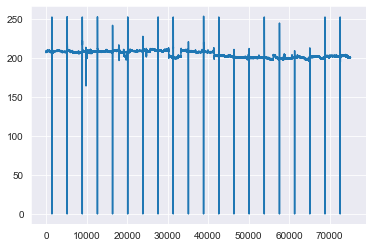

In [25]:
plt.plot(pd.Series(data=np.array(block.le_frame_val_list)))

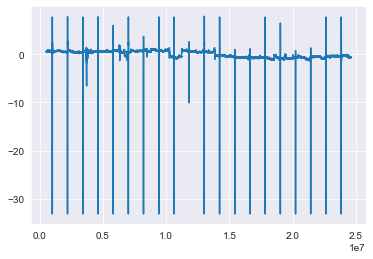

In [26]:
plt.plot(block.eye_brightness_df.L_values)

In [27]:
block.get_eyes_diff_list(2)

index error on position 61 out of 62
index error on position 49 out of 50
The suspected lag between eye cameras is 68.0 with the direction ['left', 'late']


In [29]:
block.fix_eye_synchronization()

created manual_sync_df attribute for the block


In [30]:
full_sync_verification(block)


In [34]:
print(block.final_sync_df.head())

   Arena_TTL  Arena_frame  L_eye_frame  R_eye_frame  L_values  R_values
0   525019.0        534.0         72.0          8.0  0.573617  0.172625
1   525357.0        535.0         73.0          9.0  0.532124  0.172625
2   525695.0        536.0         74.0         10.0  0.545264  0.188799
3   526033.0        537.0         75.0         11.0  0.572926  0.162516
4   526372.0        538.0         76.0         12.0  0.542498  0.177073


In [25]:
block.manual_sync_df

,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
Arena_TTL,,,,,
840447.0,407,NaN,85,NaN,0.215534
840786.0,408,NaN,86,NaN,0.145452
841124.0,409,NaN,87,NaN,0.167931
841462.0,410,NaN,88,NaN,0.156030
841800.0,411,NaN,89,NaN,0.116361
...,...,...,...,...,...
19800028.0,56452,58996,NaN,-0.416388,NaN
19800366.0,56453,58997,NaN,-0.417114,NaN
19800704.0,56454,58998,NaN,-0.417477,NaN


In [72]:
# use this to manually shift L\R eye synchronization
eye_to_move = 'R'
block.move_eye_sync_manual(cols_to_move=[f'{eye_to_move}_eye_frame',f'{eye_to_move}_values'],step=+8)

In [73]:
block.full_sync_verification(ms_axis=False,with_arena=False)

In [32]:
block.export_manual_sync_df()
block.import_manual_sync_df()

In [8]:
block.import_manual_sync_df()

there is no manual sync file for block 001, manually sync the block


In [15]:
def full_sync_verification(self):
    from bokeh.plotting import figure, show, curdoc
    from bokeh.models import Slider, ColumnDataSource, CustomJS
    from bokeh.layouts import column
    import numpy as np
    data_dict = {
    'L_values': [None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['L_values']],
    'R_values': [None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['R_values']]
    }
    source = ColumnDataSource(data=dict(
    x_axis=self.manual_sync_df.index / self.sample_rate,
    left_y=[None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['L_values'].shift(0)],
    right_y=[None if np.isnan(x) or np.isinf(x) else x for x in
    self.manual_sync_df['R_values'].shift(0)]
    ))
    bokeh_fig = figure(
    title=f'Full Synchronization Verification',
    x_axis_label='Seconds',
    y_axis_label='Brightness Z_Score',
    plot_width=1500,
    plot_height=700
    )
    left_line = bokeh_fig.line('x_axis', 'left_y', source=source,
    legend_label='Left_eye_values', line_width=1,
    line_color='blue')
    right_line = bokeh_fig.line('x_axis', 'right_y', source=source,
    legend_label='Right_eye_values', line_width=1,
    line_color='red')
    slider_left = Slider(start=-200, end=200, value=0, step=1, title="Left Eye Shift")
    slider_right = Slider(start=-200, end=200, value=0, step=1, title="Right Eye Shift")
    callback = CustomJS(args=dict(source=source, slider_left=slider_left,
    slider_right=slider_right, data_dict=data_dict),
    code="""
    const plot_data = source.data;
    const left_shift = slider_left.value;
    const right_shift = slider_right.value;
    const left_values = data_dict['L_values'];
    const right_values = data_dict['R_values'];
    const length = plot_data['x_axis'].length;
    for (let i = 0; i < length; i++) {
    plot_data['left_y'][i] = (i + left_shift >= 0 && i +
    left_shift < length) ? left_values[i + left_shift] : null;
    plot_data['right_y'][i] = (i + right_shift >= 0 && i +
    right_shift < length) ? right_values[i + right_shift] : null;
    }
    console.log("Left shift: ", left_shift, "Right shift: ",
    right_shift); // Debug output
    source.change.emit();
    """)
    slider_left.js_on_change('value', callback)
    slider_right.js_on_change('value', callback)
    layout = column(bokeh_fig, slider_left, slider_right)
    curdoc().add_root(layout)
    show(layout)


# This section deals with correcting the arena videos and eye videos relative to the LED driver events

In [9]:
# 1. Prep DataFrame and clean up infinite values
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

df = block.final_sync_df.copy()

# Ensure Arena_TTL is a column
if 'Arena_TTL' not in df.columns:
    df = df.reset_index().rename(columns={'index':'Arena_TTL'})

# Clean NaN/inf in brightness
L = df['L_values'].replace([np.inf, -np.inf], np.nan)
R = df['R_values'].replace([np.inf, -np.inf], np.nan)

# 2. Get the LED-driver event sample numbers
led_samples = (
    block.oe_events['LED_driver']
         .dropna()
         .astype(int)
         .unique()
)

# 3. Build a ColumnDataSource
source = ColumnDataSource(dict(
    x = df['Arena_TTL'].values,
    L = [None if np.isnan(v) else v for v in L],
    R = [None if np.isnan(v) else v for v in R],
))

# 4. Create the Bokeh figure
p = figure(
    title='Sync Verification (Arena_TTL) with LED Events',
    x_axis_label='Arena_TTL (OE sample #)',
    y_axis_label='Brightness Z-score',
    plot_width=1200, plot_height=500,
    tools='pan,wheel_zoom,box_zoom,reset,save'
)

# 5. Plot left/right brightness
p.line('x', 'L', source=source, legend_label='L_eye', line_color='blue',  line_width=1)
p.line('x', 'R', source=source, legend_label='R_eye', line_color='red',   line_width=1)

# 6. Draw vertical segments at each LED event from y=-10 to y=+10
for sample in led_samples:
    if sample >= df['Arena_TTL'].min() and sample <= df['Arena_TTL'].max():
        p.segment(x0=sample, y0=-10, x1=sample, y1=10,
                  line_color='green', line_dash='dashed', line_width=1)

p.legend.location = 'top_left'
show(p)


In [8]:
# over here, I use Tali's DLC annotations to get brightness values around the animal's head:
# (These can be used by looking at diff values to determine LED blinking ground-truth)
# compute brightness in a head‐ROI based on DeepLabCut annotations
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

def compute_head_roi_brightness(
    video_path: str,
    annotations_csv: str,
    bodyparts: tuple = ('nose', 'left_ear', 'right_ear'),
    padding: int = 10
) -> pd.DataFrame:
    """
    For each frame in `video_path`, build a tight ROI around the specified
    bodyparts (according to the Deeplabcut CSV), compute the mean grayscale
    brightness in that ROI, and return a DataFrame of frame‐index → brightness.

    Assumes the CSV has a 3-row header (scorer / bodyparts / coords) and
    that the first column is already the zero-based frame index.
    """
    # --- 1. load annotations with the first column as the frame-index ---
    df_anno = pd.read_csv(
        annotations_csv,
        header=[0, 1, 2],
        index_col=0
    )
    # grab the actual scorer name from level 0 of the MultiIndex
    scorer = df_anno.columns.levels[0][0]

    # --- 2. open video capture ---
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")

    results = []
    # use the annotation index (frame numbers) for iteration
    for frame_idx, row in tqdm(df_anno.iterrows(), total=len(df_anno), desc="Frames"):
        ret, frame = cap.read()
        if not ret:
            break

        # extract keypoint coords for this frame
        xs = [row[(scorer, bp, 'x')] for bp in bodyparts]
        ys = [row[(scorer, bp, 'y')] for bp in bodyparts]

        # compute bounding box + padding, clipped to image
        h, w = frame.shape[:2]
        x_min = max(int(min(xs) - padding), 0)
        x_max = min(int(max(xs) + padding), w - 1)
        y_min = max(int(min(ys) - padding), 0)
        y_max = min(int(max(ys) + padding), h - 1)

        # extract ROI and compute mean brightness
        roi = frame[y_min:y_max, x_min:x_max]
        gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        mean_brightness = float(np.mean(gray))

        results.append({
            'frame': frame_idx,
            'brightness': mean_brightness
        })

    cap.release()
    return pd.DataFrame(results)


# Example usage:
head_brightness_df = compute_head_roi_brightness(
    'Z:/Nimrod/experiments/PV_57/2024_11_25/block_007/arena_videos/videos/top_20241125T152924.mp4',
    r'Z:/Nimrod/experiments/PV_57/2024_11_25/block_007/arena_videos/videos/top_20241125T152924DLC_Resnet50_headApr3shuffle2_snapshot_120.csv',
    bodyparts=('nose','left_ear','right_ear'),
    padding=1)
#head_brightness_df.head()



Frames: 100%|██████████| 52494/52494 [03:32<00:00, 247.09it/s]


In [12]:
block.arena_videos

[WindowsPath('Z:/Nimrod/experiments/PV_57/2024_11_25/block_007/arena_videos/videos/front_20241125T152924.mp4'),
 WindowsPath('Z:/Nimrod/experiments/PV_57/2024_11_25/block_007/arena_videos/videos/left_20241125T152924.mp4'),
 WindowsPath('Z:/Nimrod/experiments/PV_57/2024_11_25/block_007/arena_videos/videos/right_20241125T152924.mp4'),
 WindowsPath('Z:/Nimrod/experiments/PV_57/2024_11_25/block_007/arena_videos/videos/top_20241125T152924.mp4')]

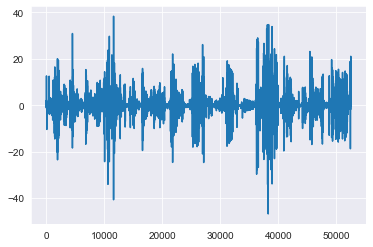

In [9]:
plt.plot(head_brightness_df['brightness'].diff())

In [10]:
# Jupyter cell: add head‐brightness diff trace to the sync verification plot

import pandas as pd
import numpy as np

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Span, Slider, CustomJS
from bokeh.layouts import column

# 1. Prepare your final_sync_df
df_sync = block.final_sync_df.copy()
if 'Arena_TTL' not in df_sync.columns:
    df_sync = df_sync.reset_index().rename(columns={'index':'Arena_TTL'})
# 2. Compute head‐ROI brightness diff
hb = head_brightness_df.copy()                    # assume this exists in your namespace
hb['diff'] = hb['brightness'].diff()

# 3. Build mapping: Arena_frame → Arena_TTL
mapping = dict(zip(df_sync['Arena_frame'], df_sync['Arena_TTL']))

# 4. Map each head‐frame diff to its Arena_TTL (skip frames not in mapping)
head_map = { mapping[f]: d
             for f, d in zip(hb['frame'], hb['diff'])
             if f in mapping }

# 5. Clean your eye‐brightness vectors
L = df_sync['L_values'].replace([np.inf, -np.inf], np.nan)
R = df_sync['R_values'].replace([np.inf, -np.inf], np.nan)

# 6. Prepare arrays for plotting
ttls     = df_sync['Arena_TTL'].values
left_y   = [None if np.isnan(v) else v for v in L]
right_y  = [None if np.isnan(v) else v for v in R]
head_y   = [ head_map.get(ttl, None) for ttl in ttls ]  # diff trace

# 7. Extract LED-driver event sample numbers
led_samples = block.oe_events['LED_driver'].dropna().astype(int).unique()

# 8. ColumnDataSources
source = ColumnDataSource(data=dict(
    x = ttls,
    L = left_y,
    R = right_y,
    H = head_y
))
events_source = ColumnDataSource(data=dict(
    orig_x = led_samples,
    x0     = led_samples,
    y0     = [-10]*len(led_samples),
    x1     = led_samples,
    y1     = [ 10]*len(led_samples),
))

# 9. Build the figure
p = figure(
    title='Sync Verification: Eyes & Head‐ROI Diff',
    x_axis_label='Arena_TTL (OE sample #)',
    y_axis_label='Brightness Z-score / ΔBrightness',
    plot_width=1200, plot_height=500,
    tools='pan,wheel_zoom,box_zoom,reset,save'
)

# Eye brightness traces
p.line('x', 'L', source=source, legend_label='L_eye',  line_color='blue',  line_width=1)
p.line('x', 'R', source=source, legend_label='R_eye',  line_color='red',   line_width=1)

# Head‐ROI diff trace
p.line('x', 'H', source=source, legend_label='Head Δ', line_color='black', line_width=1)

# LED‐driver event segments
p.segment(x0='x0', y0='y0', x1='x1', y1='y1', source=events_source,
          line_color='green', line_dash='dashed', line_width=1)

p.legend.location = 'top_left'

# 10. Slider to shift LED events
slider = Slider(start=-40000, end=40000, value=0, step=1, title='LED-event shift (samples)')
callback = CustomJS(args=dict(events=events_source, slider=slider), code="""
    const data = events.data;
    const orig = data['orig_x'];
    const shift = slider.value;
    for (let i = 0; i < orig.length; i++) {
        data['x0'][i] = orig[i] + shift;
        data['x1'][i] = orig[i] + shift;
    }
    events.change.emit();
""")
slider.js_on_change('value', callback)

# 11. Show the interactive layout
layout = column(p, slider)
show(layout)


In [78]:
block.final_sync_df

,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,695905.0,368.0,142.0,72.0,-0.034811,-0.622838
1,696238.0,369.0,143.0,73.0,-0.033420,-0.624309
2,696561.0,369.0,144.0,74.0,-0.032600,-0.623545
3,696894.0,370.0,145.0,75.0,-0.029220,-0.623072
4,697218.0,370.0,146.0,76.0,-0.021908,-0.626490
...,...,...,...,...,...,...
160542,53407754.0,80639.0,NaN,NaN,NaN,NaN
160543,53408087.0,80640.0,NaN,NaN,NaN,NaN
160544,53408411.0,80640.0,NaN,NaN,NaN,NaN
160545,53408744.0,80641.0,NaN,NaN,NaN,NaN


In [11]:
full_sync_verification(block)

In [38]:
block.manual_sync_df.rename(columns={'Unnamed: 0.1': 'Arena_TTL'},inplace=True)

In [39]:
block.manual_sync_df

,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,913655,845.0,6.0,2.0,-0.970385,-0.877140
1,913988,846.0,6.0,3.0,-0.970385,-0.872642
2,914321,846.0,8.0,4.0,-0.969849,-0.871553
3,914655,847.0,9.0,5.0,-0.966254,-0.868974
4,914988,847.0,10.0,6.0,-0.970299,-0.867236
...,...,...,...,...,...,...
121570,41436988,62567.0,121799.0,121794.0,-0.277042,0.023131
121571,41437321,62567.0,121799.0,NaN,-0.277042,NaN
121572,41437655,62568.0,121800.0,NaN,-0.285377,NaN
121573,41437988,62568.0,121802.0,NaN,-0.269196,NaN


In [167]:
block.left_eye_data

,OE_timestamp,eye_frame,ms_axis,center_x,center_y,phi,width,height,major_ax,minor_ax,ratio
0,676740.0,5.0,33837.00,319.518120,177.992945,-15.443761,46.028471,40.458124,46.028471,40.458124,1.137682
1,677073.0,6.0,33853.65,319.537921,177.984564,-15.536813,46.187965,40.480872,46.187965,40.480872,1.140982
2,677397.0,7.0,33869.85,319.510882,178.011487,-15.462979,46.079456,40.440812,46.079456,40.440812,1.139430
3,677730.0,8.0,33886.50,319.491438,178.003452,-14.895568,45.985501,40.541131,45.985501,40.541131,1.134293
4,678053.0,9.0,33902.65,319.491147,178.091727,-14.170065,45.875067,40.475895,45.875067,40.475895,1.133392
...,...,...,...,...,...,...,...,...,...,...,...
97994,32834371.0,96856.0,1641718.55,340.761068,109.354315,-24.174997,41.280409,28.235806,41.280409,28.235806,1.461988
97995,32834704.0,96857.0,1641735.20,340.931360,109.326126,-24.160139,41.655405,28.352723,41.655405,28.352723,1.469185
97996,32835027.0,96858.0,1641751.35,340.753870,109.435444,-24.996913,42.075840,28.446548,42.075840,28.446548,1.479119
97997,32835360.0,96859.0,1641768.00,341.181379,109.345112,-23.876929,41.828722,28.359923,41.828722,28.359923,1.474924


In [ ]:
# This bit of code goes over blocks and collects the median distance between the rostral and caudal edges
import os
from ellipse import LsqEllipse
import scipy.stats as stats

def eye_tracking_analysis(dlc_video_analysis_csv, uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
    # import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)

    # sort the pupil elements to dfs: x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])

    # get X coords
    pupil_xs_before_flip = data[pupil_elements[np.arange(0, len(pupil_elements), 3)]]

    # flip the data around the midpoint of the x-axis (shooting the eye through a camera flips right and left)
    pupil_xs = 320 * 2 - pupil_xs_before_flip

    # get Y coords (no need to flip as opencv conventions already start with origin at top left of frame
    # and so, positive Y is maintained as up in a flipped image as we have)
    pupil_ys = data[pupil_elements[np.arange(1, len(pupil_elements), 3)]]
    pupil_ps = data[pupil_elements[np.arange(2, len(pupil_elements), 3)]]

    # rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns, pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns, pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]

    # Do the same for the edges
    edge_elements = np.array([x for x in data.columns if 'edge' in x])
    edge_xs_before_flip = data[edge_elements[np.arange(0, len(edge_elements), 3)]]
    edge_xs = 320*2 - edge_xs_before_flip
    edge_ys = data[edge_elements[np.arange(1, len(edge_elements), 3)]]
    edge_ps = data[edge_elements[np.arange(2,len(edge_elements),3)]]
    edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns,edge_xs.columns)))
    edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns,edge_xs.columns)))
    good_edge_points = edge_ps < uncertainty_thr
    
    # work row by row to figure out the ellipses
    ellipses = []
    caudal_edge_ls = []
    rostral_edge_ls = []
    for row in tqdm.tqdm(range(1, len(data) - 1)):
        # first, take all the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values, y_values]

        # now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]

        # if there are enough rows for a fit, make an ellipse
        if X.shape[0] > 5:
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x, center_y, width, height, phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])

        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)


    # ellipse_df = pd.DataFrame(columns=['center_x', 'center_y', 'width', 'height', 'phi'], data=ellipses)
    # a = np.array(ellipse_df['height'][:])
    # b = np.array(ellipse_df['width'][:])
    # ellipse_size_per_frame = a * b * math.pi
    # ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df = pd.Dataframe({
        'rostral_edge':rostral_edge_ls,
        'caudal_edge': caudal_edge_ls
    })
    

    print(f'\n ellipses calculation complete')
    
    ellipse_df[['caudal_edge_x', 'caudal_edge_y']] = pd.DataFrame(ellipse_df['caudal_edge'].tolist(), index=ellipse_df.index)
    ellipse_df[['rostral_edge_x', 'rostral_edge_y']] = pd.DataFrame(ellipse_df['rostral_edge'].tolist(), index=ellipse_df.index)
    
    return ellipse_df

def get_pixel_distance(df):
    distances = np.sqrt((df['caudal_edge_x'] - df['rostral_edge_x'])**2 + 
                        (df['caudal_edge_y'] - df['rostral_edge_y'])**2)
    
    mean_distance = np.nanmean(distances)
    std_distance = np.nanstd(distances)
    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(distances)
    print(f"Shapiro-Wilk Test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")
    
    # Kolmogorov-Smirnov Test
    ks_test = stats.kstest(distances, 'norm', args=(mean_distance, std_distance))
    print(f"Kolmogorov-Smirnov Test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
    
    median_distance = np.median(distances)
    iqr_distance = stats.iqr(distances)
    print(f"Median Distance: {median_distance}")
    print(f"IQR: {iqr_distance}")
    print(f'mean = {mean_distance}')
    print(f'std = {std_distance}')
    return median_distance

R_pix_distance_dict = {}
L_pix_distance_dict = {}

for block in block_collection:
    print(f'working on {block}')
    pl = [i for i in os.listdir(block.r_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    R_csv  = pd.read_csv(block.r_e_path / pl, header=1)
    
    pl = [i for i in os.listdir(block.l_e_path) if 'DLC' in i and '.csv' in i]
    if len(pl) > 1:
        pl = [i for i in pl if 'filtered' in i][0]
    else:
        pl = pl[0]
    L_csv  = pd.read_csv(block.l_e_path / pl, header=1)
    R_ellipse_df = eye_tracking_analysis(R_csv,0.998)
    print('working on the right eye')
    R_pixel_distance = get_pixel_distance(R_ellipse_df)    
    L_ellipse_df = eye_tracking_analysis(L_csv,0.998)
    print('working on the left eye')
    L_pixel_distance = get_pixel_distance(L_ellipse_df)
    R_pix_distance_dict[block.block_num] = R_pixel_distance
    L_pix_distance_dict[block.block_num] = L_pixel_distance
    

In [7]:
def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')



In [8]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:

    block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
    block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
    block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder


In [9]:
block.final_sync_df.columns

Index(['Arena_TTL', 'Arena_frame', 'L_eye_frame', 'R_eye_frame', 'L_values',
       'R_values'],
      dtype='object')

In [366]:
block.left_eye_data

,OE_timestamp,eye_frame,ms_axis,center_x,center_y,ellipse_phi,width,height,major_ax,minor_ax,ratio,xgb_theta,xgb_phi,phi,theta,pupil_diameter_pixels,pupil_diameter
0,565951.0,1.0,28297.55,444.632190,206.829264,83.016304,45.335549,32.726528,45.335549,32.726528,1.385284,NaN,NaN,41.484692,-28.411240,284.851657,12.818325
1,566291.0,2.0,28314.55,444.501312,206.839827,83.435273,45.316501,32.731487,45.316501,32.731487,1.384493,NaN,NaN,41.484692,-28.411240,284.731971,12.812939
2,566631.0,3.0,28331.55,444.489259,206.843911,83.266029,45.292542,32.789987,45.292542,32.789987,1.381292,NaN,NaN,41.484692,-28.411240,284.581437,12.806165
3,566970.0,4.0,28348.50,444.515784,206.859801,83.509805,45.268229,32.769033,45.268229,32.769033,1.381433,NaN,NaN,41.484692,-28.411240,284.428670,12.799290
4,567310.0,5.0,28365.50,444.444498,206.920830,83.589111,45.316728,32.700692,45.316728,32.700692,1.385803,NaN,NaN,41.484692,-28.411240,284.733399,12.813003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99203,34261949.0,101272.0,1713097.45,412.843225,200.260902,66.957846,46.307113,37.235502,46.307113,37.235502,1.243628,NaN,NaN,39.517727,-33.517628,290.956173,13.093028
99204,34262289.0,101273.0,1713114.45,412.871902,200.210474,66.951497,46.246748,37.140492,46.246748,37.140492,1.245184,NaN,NaN,39.517727,-33.517628,290.576885,13.075960
99205,34262628.0,101274.0,1713131.40,412.912947,200.210626,66.240158,46.229480,37.094161,46.229480,37.094161,1.246274,NaN,NaN,39.518051,-33.517628,290.468388,13.071077
99206,34262968.0,101275.0,1713148.40,413.046975,200.175398,66.738613,46.132734,36.995682,46.132734,36.995682,1.246976,NaN,NaN,39.518051,-33.517628,289.860518,13.043723


In [375]:
block.left_eye_data

,OE_timestamp,eye_frame,ms_axis,center_x,center_y,ellipse_phi,width,height,major_ax,minor_ax,ratio,xgb_theta,xgb_phi,phi,theta,pupil_diameter_pixels,pupil_diameter
0,565951.0,1.0,28297.55,444.632190,206.829264,83.016304,45.335549,32.726528,45.335549,32.726528,1.385284,NaN,NaN,41.484692,-28.411240,284.851657,12.818325
1,566291.0,2.0,28314.55,444.501312,206.839827,83.435273,45.316501,32.731487,45.316501,32.731487,1.384493,NaN,NaN,41.484692,-28.411240,284.731971,12.812939
2,566631.0,3.0,28331.55,444.489259,206.843911,83.266029,45.292542,32.789987,45.292542,32.789987,1.381292,NaN,NaN,41.484692,-28.411240,284.581437,12.806165
3,566970.0,4.0,28348.50,444.515784,206.859801,83.509805,45.268229,32.769033,45.268229,32.769033,1.381433,NaN,NaN,41.484692,-28.411240,284.428670,12.799290
4,567310.0,5.0,28365.50,444.444498,206.920830,83.589111,45.316728,32.700692,45.316728,32.700692,1.385803,NaN,NaN,41.484692,-28.411240,284.733399,12.813003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99203,34261949.0,101272.0,1713097.45,412.843225,200.260902,66.957846,46.307113,37.235502,46.307113,37.235502,1.243628,NaN,NaN,39.517727,-33.517628,290.956173,13.093028
99204,34262289.0,101273.0,1713114.45,412.871902,200.210474,66.951497,46.246748,37.140492,46.246748,37.140492,1.245184,NaN,NaN,39.517727,-33.517628,290.576885,13.075960
99205,34262628.0,101274.0,1713131.40,412.912947,200.210626,66.240158,46.229480,37.094161,46.229480,37.094161,1.246274,NaN,NaN,39.518051,-33.517628,290.468388,13.071077
99206,34262968.0,101275.0,1713148.40,413.046975,200.175398,66.738613,46.132734,36.995682,46.132734,36.995682,1.246976,NaN,NaN,39.518051,-33.517628,289.860518,13.043723


In [382]:
block.final_sync_df[['Arena_TTL','Arena_frame']]

,Arena_TTL,Arena_frame
0,565951.0,913.0
1,566291.0,914.0
2,566631.0,915.0
3,566970.0,916.0
4,567310.0,917.0
...,...,...
99203,34261949.0,100116.0
99204,34262289.0,100117.0
99205,34262628.0,100118.0
99206,34262968.0,100119.0


In [380]:
block.final_sync_df.head()

,Unnamed: 0.1,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,0,565951.0,913.0,1.0,NaN,-2.646521,NaN
1,1,566291.0,914.0,2.0,NaN,-2.646440,NaN
2,2,566631.0,915.0,3.0,NaN,-2.646465,NaN
3,3,566970.0,916.0,4.0,NaN,-2.641369,NaN
4,4,567310.0,917.0,5.0,2.0,-2.641731,0.554543


In [392]:

def create_sync_dataframe(block):
    """
    Constructs a synchronization dataframe for video synchronization.

    Parameters:
        block: BlockSync object containing synchronization data and eye data.

    Returns:
        pd.DataFrame: A dataframe with integrated synchronization data for arena and eye videos.
    """
    # Start with the final_sync_df
    try:
        sync_df = block.final_sync_df[['Arena_TTL', 'Arena_frame']].copy()
        sync_df.rename(columns={'Arena_TTL': 'OE_timestamp'}, inplace=True)
    except KeyError:
        sync_df = block.final_sync_df[['OE_timestamp','Arena_frame']].copy()

    # Merge with left eye data
    left_eye_data = block.left_eye_data[['OE_timestamp', 'eye_frame']].rename(columns={'eye_frame': 'L_eye_frame'})
    sync_df = pd.merge(sync_df, left_eye_data, on='OE_timestamp', how='left')

    # Merge with right eye data
    right_eye_data = block.right_eye_data[['OE_timestamp', 'eye_frame']].rename(columns={'eye_frame': 'R_eye_frame'})
    sync_df = pd.merge(sync_df, right_eye_data, on='OE_timestamp', how='left')

    return sync_df

# Example Usage
sync_df = create_sync_dataframe(block)

In [391]:
block.final_sync_df

,Unnamed: 0.1,OE_timestamp,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,0,565951.0,913.0,1.0,NaN,-2.646521,NaN
1,1,566291.0,914.0,2.0,NaN,-2.646440,NaN
2,2,566631.0,915.0,3.0,NaN,-2.646465,NaN
3,3,566970.0,916.0,4.0,NaN,-2.641369,NaN
4,4,567310.0,917.0,5.0,2.0,-2.641731,0.554543
...,...,...,...,...,...,...,...
99203,99203,34261949.0,100116.0,101272.0,101271.0,0.072080,-1.185376
99204,99204,34262289.0,100117.0,101273.0,101272.0,0.072150,-1.185574
99205,99205,34262628.0,100118.0,101274.0,101273.0,0.072569,-1.186444
99206,99206,34262968.0,100119.0,101275.0,101274.0,0.075081,-1.186171


In [387]:
block.final_sync_df

,Unnamed: 0.1,Arena_TTL,Arena_frame,L_eye_frame,R_eye_frame,L_values,R_values
0,0,565951.0,913.0,1.0,NaN,-2.646521,NaN
1,1,566291.0,914.0,2.0,NaN,-2.646440,NaN
2,2,566631.0,915.0,3.0,NaN,-2.646465,NaN
3,3,566970.0,916.0,4.0,NaN,-2.641369,NaN
4,4,567310.0,917.0,5.0,2.0,-2.641731,0.554543
...,...,...,...,...,...,...,...
99203,99203,34261949.0,100116.0,101272.0,101271.0,0.072080,-1.185376
99204,99204,34262289.0,100117.0,101273.0,101272.0,0.072150,-1.185574
99205,99205,34262628.0,100118.0,101274.0,101273.0,0.072569,-1.186444
99206,99206,34262968.0,100119.0,101275.0,101274.0,0.075081,-1.186171


In [388]:
def compare_eye_frames(new_sync_df, final_sync_df):
    """
    Compares the L_eye_frame and R_eye_frame columns between new_sync_df and final_sync_df.

    Parameters:
        new_sync_df (pd.DataFrame): The newly created synchronization dataframe.
        final_sync_df (pd.DataFrame): The original synchronization dataframe.

    Returns:
        dict: A dictionary with mismatches and summary statistics.
    """
    final_sync_df.rename(columns={'Arena_TTL': 'OE_timestamp'}, inplace=True)
    # Merge the dataframes on OE_timestamp for alignment
    comparison_df = pd.merge(
        new_sync_df[['OE_timestamp', 'L_eye_frame', 'R_eye_frame']],
        final_sync_df[['OE_timestamp', 'L_eye_frame', 'R_eye_frame']],
        on='OE_timestamp',
        suffixes=('_new', '_final'),
        how='inner'
    )

    # Compare the columns
    comparison_df['L_eye_mismatch'] = comparison_df['L_eye_frame_new'] != comparison_df['L_eye_frame_final']
    comparison_df['R_eye_mismatch'] = comparison_df['R_eye_frame_new'] != comparison_df['R_eye_frame_final']

    # Identify mismatches
    l_eye_mismatches = comparison_df[comparison_df['L_eye_mismatch']]
    r_eye_mismatches = comparison_df[comparison_df['R_eye_mismatch']]

    # Summary statistics
    mismatch_summary = {
        'total_frames': len(comparison_df),
        'L_eye_mismatches': len(l_eye_mismatches),
        'R_eye_mismatches': len(r_eye_mismatches),
        'L_eye_mismatch_percentage': len(l_eye_mismatches) / len(comparison_df) * 100,
        'R_eye_mismatch_percentage': len(r_eye_mismatches) / len(comparison_df) * 100,
    }

    return {
        'comparison_df': comparison_df,
        'l_eye_mismatches': l_eye_mismatches,
        'r_eye_mismatches': r_eye_mismatches,
        'mismatch_summary': mismatch_summary
    }

# Example Usage
results = compare_eye_frames(sync_df, block.final_sync_df)

# Display summary of mismatches
print("Mismatch Summary:")
for key, value in results['mismatch_summary'].items():
    print(f"{key}: {value}")

# Optionally, save the comparison dataframe to a CSV for detailed analysis
results['comparison_df'].to_csv("eye_frame_comparison.csv", index=False)


Mismatch Summary:
total_frames: 99208
L_eye_mismatches: 20951
R_eye_mismatches: 10525
L_eye_mismatch_percentage: 21.118256592210304
R_eye_mismatch_percentage: 10.609023465849528


In [180]:
# Synchronized playback based on block.final_sync_df
import cv2
import numpy as np
import pandas as pd
import time

def display_synchronized_frames(sync_df, arena_vid, left_vid, right_vid):
    """
    Displays synchronized frames from three video sources with options for manual control and rolling playback.

    Parameters:
        sync_df (pd.DataFrame): A dataframe with columns ['Arena_frame', 'L_eye_frame', 'R_eye_frame'].
        arena_vid (str): Path to the arena video file.
        left_vid (str): Path to the left eye video file.
        right_vid (str): Path to the right eye video file.
    """
    # Open video capture objects
    arena_cap = cv2.VideoCapture(arena_vid)
    left_cap = cv2.VideoCapture(left_vid)
    right_cap = cv2.VideoCapture(right_vid)

    if not (arena_cap.isOpened() and left_cap.isOpened() and right_cap.isOpened()):
        print("Error: Could not open one or more video files.")
        return

    # Function to resize frames while keeping aspect ratio
    def resize_frame(frame, scale, canvas):
        new_w, new_h = int(frame.shape[1] * scale), int(frame.shape[0] * scale)
        resized = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)
        canvas.fill(0)
        canvas[(canvas.shape[0] - new_h) // 2:(canvas.shape[0] - new_h) // 2 + new_h,
               (canvas.shape[1] - new_w) // 2:(canvas.shape[1] - new_w) // 2 + new_w] = resized
        return canvas

    # Parameters for display
    window_size = (640, 480)  # Default window size for each video
    cv2.namedWindow("Arena View", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Left Eye View", cv2.WINDOW_NORMAL)
    cv2.namedWindow("Right Eye View", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Arena View", window_size[0], window_size[1])
    cv2.resizeWindow("Left Eye View", window_size[0], window_size[1])
    cv2.resizeWindow("Right Eye View", window_size[0], window_size[1])

    # Precompute scaling factors and allocate canvases
    scale_arena = min(window_size[0] / arena_cap.get(cv2.CAP_PROP_FRAME_WIDTH),
                      window_size[1] / arena_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    scale_eye = min(window_size[0] / left_cap.get(cv2.CAP_PROP_FRAME_WIDTH),
                    window_size[1] / left_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    arena_canvas = np.zeros((window_size[1], window_size[0], 3), dtype=np.uint8)
    left_canvas = np.zeros((window_size[1], window_size[0], 3), dtype=np.uint8)
    right_canvas = np.zeros((window_size[1], window_size[0], 3), dtype=np.uint8)

    current_idx = 0
    max_idx = len(sync_df)
    rolling_playback = False
    slo_mo = 0
    # Main loop for displaying frames
    while True:
        row = sync_df.iloc[current_idx]
        arena_frame, left_frame, right_frame = row['Arena_frame'], row['L_eye_frame'], row['R_eye_frame']

        # Retrieve frames (sequential read during rolling playback, seeking otherwise)
        if rolling_playback:
            if slo_mo % 2 == 0:
                time.sleep(1 / 60)  # Playback at 60 fps

            if current_idx < max_idx - 1:
                current_idx += 1
                arena_img = arena_cap.read()[1] if not pd.isna(arena_frame) else None
                left_img = left_cap.read()[1] if not pd.isna(left_frame) else None
                right_img = right_cap.read()[1] if not pd.isna(right_frame) else None
            else:
                rolling_playback = False  # Stop playback at the last frame
        else:
            arena_cap.set(cv2.CAP_PROP_POS_FRAMES, arena_frame if not pd.isna(arena_frame) else 0)
            left_cap.set(cv2.CAP_PROP_POS_FRAMES, left_frame if not pd.isna(left_frame) else 0)
            right_cap.set(cv2.CAP_PROP_POS_FRAMES, right_frame if not pd.isna(right_frame) else 0)
            arena_img = arena_cap.read()[1] if not pd.isna(arena_frame) else None
            left_img = left_cap.read()[1] if not pd.isna(left_frame) else None
            right_img = right_cap.read()[1] if not pd.isna(right_frame) else None

        # Prepare display images
        def prepare_display(image, scale, canvas, flip=False):
            if image is None:
                display = np.zeros(canvas.shape, dtype=np.uint8)
                cv2.putText(display, "No synchronized frame", (50, canvas.shape[0] // 2),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            else:
                if flip:
                    image = cv2.flip(cv2.flip(image, 0), 1)  # Flip vertically and horizontally
                display = resize_frame(image, scale, canvas)
            return display

        arena_display = prepare_display(arena_img, scale_arena, arena_canvas)
        left_display = prepare_display(left_img, scale_eye, left_canvas, flip=True)
        right_display = prepare_display(right_img, scale_eye, right_canvas, flip=True)

        # Show frames in separate windows
        cv2.imshow("Arena View", arena_display)
        cv2.imshow("Left Eye View", left_display)
        cv2.imshow("Right Eye View", right_display)

        # Clear the console and print updated frame info
        print(f"\rFrame Info: Arena: {arena_frame}, Left Eye: {left_frame}, Right Eye: {right_frame} (Index: {current_idx})", end='', flush=True)

        # Handle keyboard events
        if not rolling_playback:
            key = cv2.waitKey(0) & 0xFF
            if key == ord('q'):  # Quit
                break
            elif key == ord('n'):  # Step backward
                current_idx = max(0, current_idx - 1)
            elif key == ord('c'):  # Step backward by 30 frames
                current_idx = max(0, current_idx - 30)
            elif key == ord('m'):  # Step forward
                current_idx = min(max_idx - 1, current_idx + 1)
            elif key == ord('v'):  # Step forward by 30 frames
                current_idx = min(max_idx - 1, current_idx + 30)
            elif key == ord('f'):  # Step forward by 120 frames
                current_idx = min(max_idx - 1, current_idx + 120)
            elif key == ord('p'):  # Start rolling playback
                rolling_playback = True
        else:
            if cv2.waitKey(1) & 0xFF == ord('p'):  # Stop rolling playback
                rolling_playback = False
            elif cv2.waitKey(1) & 0xFF == ord('o'):
                slo_mo += 1

    # Release video captures and destroy windows
    arena_cap.release()
    left_cap.release()
    right_cap.release()
    cv2.destroyAllWindows()




arena_vid = r'X:\Nimrod\experiments\PV_106\2025_08_06\block_013\arena_videos\videos/top_20250806T140238.avi'
left_vid = block.le_videos[0]
right_vid = block.re_videos[0]
sync_df = block.final_sync_df
display_synchronized_frames(sync_df, arena_vid=arena_vid,left_vid=left_vid, right_vid=right_vid)

Frame Info: Arena: 1475.0, Left Eye: 793.0, Right Eye: 807.0 (Index: 758)

In [179]:
block

BlockSync object for animal PV_106 with 
block_num 013 at date PV106_ET_d3t6_2025-08-06_14-02-05